#### PACKAGES REQUIRED

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import tree

from operator import itemgetter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

#### Keywords
* Numpy
* Pandas
* Logistic Regression
* Decision Trees
* Random Forest
* Train-Test
* KFold cross validation
* Important features
* roc_auc_score, accuracy, precision, FBeta, KS

#### Data Preparation

In [2]:
# Import excel file
excel_file = r'I:\data scientist using python\sales3.xlsx'

# Creating Data Frame
df= pd.read_excel(excel_file)

# Column Name
df.drop('Name',axis=1,inplace=True)

# Column Attended
df.loc[df['Attended'].isnull(),'Attended']='Not attended'
k=pd.get_dummies(df['Attended'],drop_first=True,prefix='dum_attended')
df=pd.concat([df,k],axis=1)
del df['Attended']

# Column Company
df['Company']=df['Company'].isnull().astype(int)
df.loc[df['Company']==0,'Company']=2
df.loc[df['Company']==1,'Company']=0
df.loc[df['Company']==2,'Company']=1

# Column Call Status
df.loc[df['Call Status'].isnull(),'Call Status']='Not Answered'
df.loc[df['Call Status']=='Not Answered','Call Status']=0
df.loc[df['Call Status']=='Answered','Call Status']=1
df.loc[df['Call Status']=='Answered     ','Call Status']=1
df.loc[df['Call Status']=='Answered       ','Call Status']=1
df.loc[df['Call Status']=='Not Answered              ','Call Status']=0
df.loc[df['Call Status']=='Not Answered          ','Call Status']=0

# Column Enrollment Date,Discount,Discounts Offered
df.drop(['Enrollment Date','Discount %','Discounts Offered'],axis=1,inplace=True)

# Column Experience
df.loc[df['Experience'].isnull(),'Experience']=0

# Column First call date, last call date, follow up date
L=list(df['Follow up Date'].isnull())
for i in range(0,len(df['Follow up Date'])):
    if L[i]==True:
        df['Follow up Date'][i]=df['Last Call Date'][i]

## calculating difference between dates
date_format = "%d/%m/%Y"
diff_date=[]
L1=df['First Call Date'].isnull()
L2=df['Follow up Date'].isnull()
for i in range(0,len(df['First Call Date'])):
    if L1[i]==False and L2[i]==False:
        a = datetime.strptime(df['First Call Date'][i], date_format)
        b = datetime.strptime(df['Follow up Date'][i], date_format)
        delta = b - a
        diff_date.append(delta.days)
    else:
        diff_date.append(20)
## creating dataframe and concat with main dataframe      
dd=pd.DataFrame({"diff_date":diff_date})
dd['diff_date']=dd['diff_date'].astype(int)
df=pd.concat([df,dd],axis=1)
## Replace negative values with 0
df['diff_date']=np.where(df['diff_date']<0,0,df['diff_date'])

# Column City : Consider cities with frequencies greater than 10
freq=df['City'].value_counts()
k=freq.index[freq>=10][:-1]
for cat in k:
    name='City'+'_'+cat
    df[name]=(df['City']==cat).astype('int')
del df['City']

# Column Industry, Installment Offered
df.drop(['Industry','Installment Offered'],axis=1,inplace=True)

# Column Internship Requirement
df['dum_internship']=(df['Internship requirement']=='yes').astype(int)
del df['Internship requirement']

# Column Lead Source: Consider Lead Source with frequencies greater than 35
freq1=df['Lead Source'].value_counts()
k1=freq1.index[freq1>=35][:-1]
for cat in k1:
    name='Lead_source'+'_'+cat
    df[name]=(df['Lead Source']==cat).astype('int')
del df['Lead Source']

# Column Probable Value of Conversion
del df['Probable Value of Conversion']

# Column Qualification
freq2=df['Qualification'].value_counts()
k2=freq2.index[freq2>=10][:-1]
for cat in k2:
    name='Qualification'+'_'+cat
    df[name]=(df['Qualification']==cat).astype('int')
del df['Qualification']

# Column Reason for Loss of Order
trial=((df['Reason for Loss of Order'].isnull()).astype(int))
df['Reason_Loss_of_Order_Mentioned']=(trial==0).astype(int)
del df['Reason for Loss of Order']

# Column Remarks  Standard
df.loc[df['Remarks  Standard'].isnull(),'Remarks  Standard']='Cold'
L=['Cold','Hot','Warm']
for i in range(len(df['Remarks  Standard'])):
        if df['Remarks  Standard'][i] in L:
            pass
        else:
            df['Remarks  Standard'][i]='Other'
            
k3=pd.get_dummies(df['Remarks  Standard'],drop_first=True,prefix='lead_type')
df=pd.concat([df,k3],axis=1)
del df['Remarks  Standard']

# Column Tag
df['Lead Tag']=(df['Tag']=='Enrollments').astype(int)
del df['Tag']
df['Enrollment Response']=df['Lead Tag']
del df['Lead Tag']

# Column Date,First Call Date,Follow up Date,Last Call Date
df.drop(['Date','First Call Date','Follow up Date','Last Call Date'],axis=1,inplace=True)
   
# Randomization of rows as clustering of rows according to tags may lead to overfitting
df=df.sample(frac=1).reset_index(drop=True)

I:\anaconda new\install anaconda\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
I:\anaconda new\install anaconda\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
df.head()

,Company,Call Status,Experience,dum_attended_Not attended,dum_attended_Seminar,dum_attended_Webinar,dum_attended_Workshop,diff_date,City_Pune,City_Mumbai,...,Qualification_MCA,Qualification_BE IT,Qualification_BE Mech,Qualification_BE CS,Qualification_BTECH,Reason_Loss_of_Order_Mentioned,lead_type_Hot,lead_type_Other,lead_type_Warm,Enrollment Response
0,1,0,8.0,0,0,1,0,19,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2.0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,2.4,0,0,0,0,27,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0,1,0,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,1,0,0,0,7,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.columns

Index(['Company', 'Call Status', 'Experience', 'dum_attended_Not attended',
       'dum_attended_Seminar', 'dum_attended_Webinar', 'dum_attended_Workshop',
       'diff_date', 'City_Pune', 'City_Mumbai', 'City_Navi Mumbai',
       'City_Bangalore', 'City_Indore', 'dum_internship', 'Lead_source_Online',
       'Lead_source_Telephone', 'Lead_source_Townscript',
       'Lead_source_Reference', 'Lead_source_Monster', 'Lead_source_Chat',
       'Lead_source_zoom', 'Lead_source_Meetup', 'Lead_source_Others',
       'Qualification_BE', 'Qualification_BE CSE', 'Qualification_MBA',
       'Qualification_BE ENTC', 'Qualification_MCA', 'Qualification_BE IT',
       'Qualification_BE Mech', 'Qualification_BE CS', 'Qualification_BTECH',
       'Reason_Loss_of_Order_Mentioned', 'lead_type_Hot', 'lead_type_Other',
       'lead_type_Warm', 'Enrollment Response'],
      dtype='object')

### Model 1: Logistic Regression


In [5]:
# Train- 80% data, Test- 20% data
train,test=train_test_split(df,test_size=0.2,random_state=3)

# defining model variables: Y=F(x)  
# Y= Response(Enrollment done= 1, Enrollment not done=0)
# X= Varables on which enrollment depends
x_train=train.drop('Enrollment Response',axis=1)
y_train=train['Enrollment Response']
x_test=test.drop('Enrollment Response',axis=1)
y_test=test['Enrollment Response']

# Model fitting : Finding optimum coefficients of model equation using Least square method
logreg=LogisticRegression(class_weight='balanced',penalty='l2')
logreg.fit(x_train,y_train)

print('Intercept is ',logreg.intercept_[0])
print('-------------------------------')
print("Coefficients of variabbles are :")
coef=logreg.coef_[0][:]
for i in range(len(x_train.columns)):
    print(x_train.columns[i],':',logreg.coef_[0][i])
print('-------------------------------')
# Prediction on test data
predict_proba=logreg.predict_proba(x_test)[:,1]
print("AUC score is ",roc_auc_score(y_test,predict_proba))
print('-------------------------------')
# Deciding cutoff of probability for deciding enrollment.
# If probability>cutoff then enrollment =1 otherwise enrollment=0

cutoffs=np.linspace(0.01,0.99,99)
train_score=logreg.predict_proba(x_train)[:,1]
real=y_train

## Confusion Matrix analysis
KS_all=[]
Fbeta=[]
Accuracy=[]
Precision=[]
for cutoff in cutoffs:
    predicted=(train_score>cutoff).astype(int)
    
    TP=((predicted==1) & (real==1)).sum()
    TN=((predicted==0) & (real==0)).sum()
    FP=((predicted==1) & (real==0)).sum()
    FN=((predicted==0) & (real==1)).sum()
    P=TP+FN
    N=FP+TN
    KS=(TP/P) - (FP/N)
    prec= TP/(TP+FP)
    Recall=TP/P
    accu=(TP+TN)/(P+N)
    B=5
    Fb=((1+B*B)*prec* Recall)/(B*B*prec+Recall)
    KS_all.append(KS)
    Fbeta.append(Fb)
    Accuracy.append(accu)
    Precision.append(prec)
    
print('Cutoff for max accuracy of ',max(Accuracy)*100,'% is ',max(cutoffs[Accuracy==max(Accuracy)]))
print('Cutoff for max Precision of ',max(Precision)*100,'% is ',max(cutoffs[Precision==max(Precision)]))
print('Cutoff for max Fbeta of ',max(Fbeta),' is ',max(cutoffs[Fbeta==max(Fbeta)]))
print('Cutoff for max KS_all of ',max(KS_all),' is ',max(cutoffs[KS_all==max(KS_all)]))



Intercept is  2.4092023461040464
-------------------------------
Coefficients of variabbles are :
Company : 1.2262977242970252
Call Status : -3.7714857112641447
Experience : 0.03692594701322651
dum_attended_Not attended : -3.558036988595922
dum_attended_Seminar : -0.46139726223078625
dum_attended_Webinar : -1.1874541758915949
dum_attended_Workshop : 1.7300309151002484
diff_date : -0.020227385303704815
City_Pune : 0.061503710752973235
City_Mumbai : -0.03545325185998787
City_Navi Mumbai : -0.18931705871579127
City_Bangalore : -0.46918421070788846
City_Indore : -0.18816375640962346
dum_internship : 2.9569572875717447
Lead_source_Online : -1.0845039801523948
Lead_source_Telephone : -0.6287456760267959
Lead_source_Townscript : -1.841349622524754
Lead_source_Reference : 0.9133170472945155
Lead_source_Monster : -0.8700040213809482
Lead_source_Chat : -1.0774805610302245
Lead_source_zoom : -1.5740118048553247
Lead_source_Meetup : -0.404974215510396
Lead_source_Others : -0.6343781619664285
Quali

### Model 2: Decision Trees

In [6]:
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

x_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

dtree=tree.DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=10)
dtree.fit(x_train,y_train)
p=dtree.predict(x_test)
pb=dtree.predict_proba(x_test)[:,1]
print('-------------------------------')
print('ROC AUC Score for decision tree is ',round(roc_auc_score(y_test,pb),2))

# Creating Tree
dotfile=open("tree_prediction_sales1.dot",'w')

tree.export_graphviz(dtree,out_file=dotfile,
                    feature_names=x_train.columns,
                    class_names=['0','1'],
                    proportion=True)
dotfile.close()

# plot tree in www.webgraphviz.com using dot file generated
score=accuracy_score(y_test,p)
print('-------------------------------')
print('Accuracy Using Decision tree is ', round(score*100,2),'%')
print('-------------------------------')

-------------------------------
ROC AUC Score for decision tree is  0.99
-------------------------------
Accuracy Using Decision tree is  97.33 %
-------------------------------


### Model 3: RandomForest
* RandomForest- nullify the noise in the data by introducing randomisation at two stages. It overcomes the drawback of decision tree of overfitting of the data


In [7]:
# Defining parameters of random forest
parameters={'n_estimators':[10,50,100,300],
            'max_features':[5,10],
            'max_depth':[3,5,10,20,None],
            'min_samples_split':[2,5,10,15],
            'min_samples_leaf':[1,5,10,15],
            'criterion':['entropy','gini'],
            'bootstrap':[True,False] 
           }
# Total Combinations possible 4*2*6*4*4*2*2=3072

# Defining class
clf=RandomForestClassifier(verbose=1,n_jobs=-1)

# Searching 20 random models from 3072 combinations
# Best way is to execute all the combinations and then look for best. But in this computation effort is enormous
n_iter_search=20
random_search=RandomizedSearchCV(clf,param_distributions=parameters,n_iter=n_iter_search,scoring='roc_auc',cv=10,
                                 return_train_score=True)
random_search.fit(x_train,y_train)

# Function for report generation
def report(results,n_top=3):
    for i in range(1,n_top+1):
        candidates=np.flatnonzero(results['rank_test_score']==i)
        for candidate in candidates:
            print('Model with rank: {0}'.format(i))
            print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
            results['mean_test_score'][candidate],
            results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
# Calling the function report to get top performing model... n=3
print('Best Performing Models are :',report(random_search.cv_results_,3))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.997 (std: 0.004)
Parameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.997 (std: 0.004)
Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}

Best Performing Models are : None


In [8]:
# Best model parameters
random_search.cv_results_['params'][random_search.best_index_]

{'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': False}

In [9]:
# Defining Class for above obtained parameter combinations
rf=RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=None,max_features=10,bootstrap=True,
                         criterion='entropy',min_samples_leaf=1,class_weight='balanced',verbose=1)
# Fitting model to train data
rf.fit(x_train,y_train)

# Prediction on test data
p_rf=rf.predict_proba(x_test)[:,1]

# Performance metrics : ROC score
print('-------------------------------')
print('ROC AUC score for Random Forest model is', roc_auc_score(y_test,p_rf))
print('-------------------------------')
# Performance metrics : Accuracy
prf=rf.predict(x_test)
score1=accuracy_score(y_test,prf)
print('Accuracy Using Random Forest is ', round(score1*100,2),'%')
print('-------------------------------')

-------------------------------
ROC AUC score for Random Forest model is 0.9947380206000896
-------------------------------
Accuracy Using Random Forest is  97.63 %
-------------------------------


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [10]:
print('-------------------------------')
print('Accuracy using Logistic Regression is ',round(max(Accuracy)*100,2))
print('-------------------------------')
print('Accuracy Using Decision tree is ', round(score,2)*100,'%')
print('-------------------------------')
print('Accuracy Using Random Forest is ', round(score1*100,2),'%')
print('-------------------------------')

# Even though Accuracy of RF is less, it is much generalised model.

-------------------------------
Accuracy using Logistic Regression is  98.89
-------------------------------
Accuracy Using Decision tree is  97.0 %
-------------------------------
Accuracy Using Random Forest is  97.63 %
-------------------------------


In [11]:
# Important features Ranking
importances = rf.feature_importances_
importances


indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature Company (0.402191)
2. feature Call Status (0.140169)
3. feature Experience (0.111157)
4. feature dum_attended_Not attended (0.109411)
5. feature dum_attended_Seminar (0.049605)
6. feature dum_attended_Webinar (0.039049)
7. feature dum_attended_Workshop (0.028525)
8. feature diff_date (0.021073)
9. feature City_Pune (0.018074)
10. feature City_Mumbai (0.016726)
11. feature City_Navi Mumbai (0.011538)
12. feature City_Bangalore (0.009504)
13. feature City_Indore (0.007355)
14. feature dum_internship (0.005901)
15. feature Lead_source_Online (0.005657)
16. feature Lead_source_Telephone (0.004110)
17. feature Lead_source_Townscript (0.003009)
18. feature Lead_source_Reference (0.002954)
19. feature Lead_source_Monster (0.002630)
20. feature Lead_source_Chat (0.001865)
21. feature Lead_source_zoom (0.001644)
22. feature Lead_source_Meetup (0.001294)
23. feature Lead_source_Others (0.001185)
24. feature Qualification_BE (0.000921)
25. feature Qualification_BE CSE 

### Visualizations and recomendations

In [12]:
import seaborn as sns

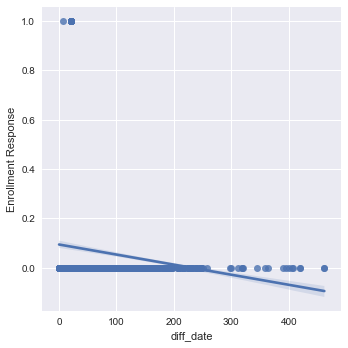

In [13]:
# DIff date
sns.set()
sns.lmplot(x="diff_date", y="Enrollment Response",
               truncate=True, size=5, data=df)


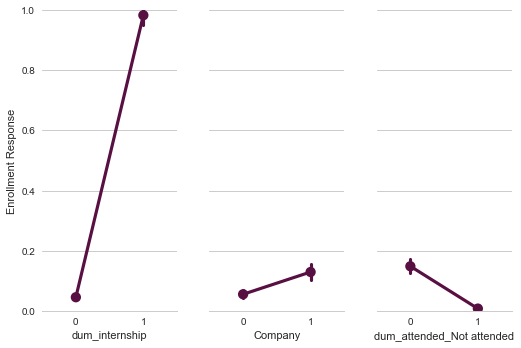

In [14]:
sns.set(style="whitegrid")
g = sns.PairGrid(df, y_vars="Enrollment Response",
                 x_vars=['dum_internship',"Company", "dum_attended_Not attended"],
                 size=5, aspect=.5)

g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

## Recommendations for team
#### following are the data driven recommendations to ensure the good probability of enrollment
* Difference between first call date and follow up date should be within 20 days
* Candidates interested in internship are more likely to get enrolled. Put more emphasis on internship availability and its benefits
* Candidates working in company are more likely to get enrolled
* Candidate attending seminar, webinar or wokshop are more likely to get enrolled. Convince an enquiry to participate in any of the activity.
* Availability of training or coaching in home city is more prefered by candidate. From current data it is observed that candidate from Pune or Mumbai is more likely to get enrolled. So importance to those candidates can be given in a city where we have facility of training.
* If candidate lead status is not interested, give less impoartance as he/she has more probability of not getting enrolled.
* It is observed that candidates having lead status of cold, warm or hot is not significant. Proper follow up is recommended for all the lead status.

In [15]:
x_train.columns

Index(['Company', 'Call Status', 'Experience', 'dum_attended_Not attended',
       'dum_attended_Seminar', 'dum_attended_Webinar', 'dum_attended_Workshop',
       'diff_date', 'City_Pune', 'City_Mumbai', 'City_Navi Mumbai',
       'City_Bangalore', 'City_Indore', 'dum_internship', 'Lead_source_Online',
       'Lead_source_Telephone', 'Lead_source_Townscript',
       'Lead_source_Reference', 'Lead_source_Monster', 'Lead_source_Chat',
       'Lead_source_zoom', 'Lead_source_Meetup', 'Lead_source_Others',
       'Qualification_BE', 'Qualification_BE CSE', 'Qualification_MBA',
       'Qualification_BE ENTC', 'Qualification_MCA', 'Qualification_BE IT',
       'Qualification_BE Mech', 'Qualification_BE CS', 'Qualification_BTECH',
       'Reason_Loss_of_Order_Mentioned', 'lead_type_Hot', 'lead_type_Other',
       'lead_type_Warm'],
      dtype='object')

In [17]:
d={}
print('Enter 1 for yes, 0 for No')
for i in x_train.columns:
    print(i,':',end='')
    x=float(input())
    d[i]=[x]
newDF = pd.DataFrame.from_dict(d) 

print('----------------------------')
ans=[float(logreg.predict_proba(newDF)[:,1]*100),float(dtree.predict_proba(newDF)[:,1]*100),float(rf.predict_proba(newDF)[:,1]*100)]
print('Probability of enrollment by model 1 is : ',float(logreg.predict_proba(newDF)[:,1]*100),'%')
print('Probability of enrollment by model 2 is : ',float(dtree.predict_proba(newDF)[:,1]*100),'%')
print('Probability of enrollment by model 3 is : ',float(rf.predict_proba(newDF)[:,1]*100),'%')
print('----------------------------')
print('Maximum Probability of enrollment is : ',max(ans),'%')


Enter 1 for yes, 0 for No
Company :0
Call Status :1
Experience :10
dum_attended_Not attended :0
dum_attended_Seminar :0
dum_attended_Webinar :1
dum_attended_Workshop :0
diff_date :10
City_Pune :1
City_Mumbai :0
City_Navi Mumbai :0
City_Bangalore :0
City_Indore :0
dum_internship :1
Lead_source_Online :0
Lead_source_Telephone :1
Lead_source_Townscript :0
Lead_source_Reference :0
Lead_source_Monster :0
Lead_source_Chat :0
Lead_source_zoom :0
Lead_source_Meetup :0
Lead_source_Others :0
Qualification_BE :1
Qualification_BE CSE :1
Qualification_MBA :0
Qualification_BE ENTC :0
Qualification_MCA :0
Qualification_BE IT :0
Qualification_BE Mech :0
Qualification_BE CS :0
Qualification_BTECH :0
Reason_Loss_of_Order_Mentioned :0
lead_type_Hot :0
lead_type_Other :1
lead_type_Warm :0
----------------------------
Probability of enrollment by model 1 is :  7.26369035105108 %
Probability of enrollment by model 2 is :  100.0 %
Probability of enrollment by model 3 is :  28.70478692586064 %
---------------

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
